# analytical method for correction of AuNRs 

In [27]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
import seaborn as sns
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

import Lorentzian

## upload data

In [4]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

## analytical method

In [5]:
def L(ratio):
    return (1 + ratio)**(-1.6)

def func(L, n, eps_inf):
    return np.sqrt(((1-L)*((n+1)**2))/(4*L) + eps_inf)

def func2(L, n, eps_inf):
    return np.sqrt(n**2/L + eps_inf - n**2)

In [7]:
# conversion factor 
n_glass = 1.52
n_ito = 1.85
eps_inf = 9.84 

# average
L_glass = L(glass_data['ratio'].mean())
L_ito = L(ito_data['ratio'].mean())

conv_factor =  func(L_glass, n_glass, eps_inf) / func(n_ito, n_ito, eps_inf) 
print(conv_factor)
# conv_factor*X['eres']

1.5902324729148873


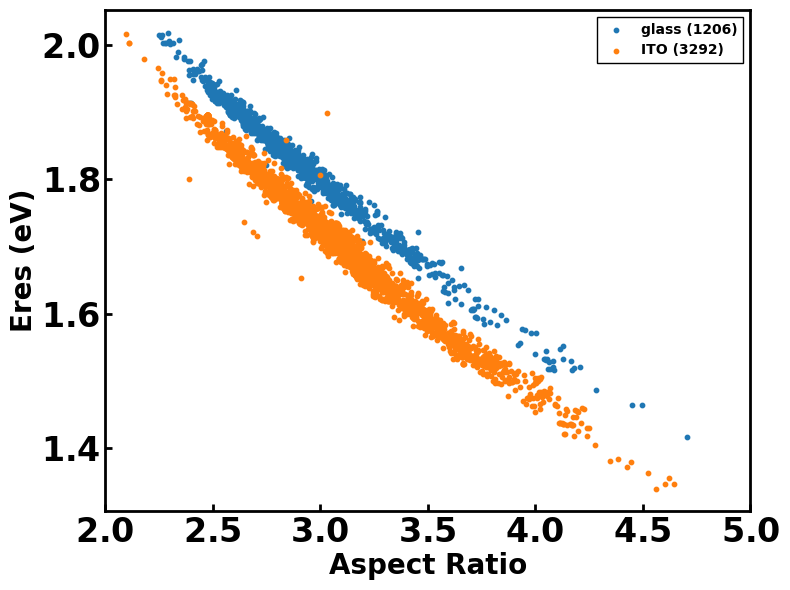

In [9]:
# Eres vs AR ITO and glass
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, label=f'glass ({glass_data.shape[0]})')
plt.scatter(ito_data['ratio'], ito_data['eres'], s=10, label=f'ITO ({ito_data.shape[0]})')

# plt.scatter(glass_data['ratio'], glass_data['eres']*conv_factor, s=10, label=f'glass ({glass_data.shape[0]})')
# plt.scatter(ito_data['ratio'], ito_data['eres'], s=10, label=f'ITO ({ito_data.shape[0]})')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xlim(2, 5)
plt.legend()

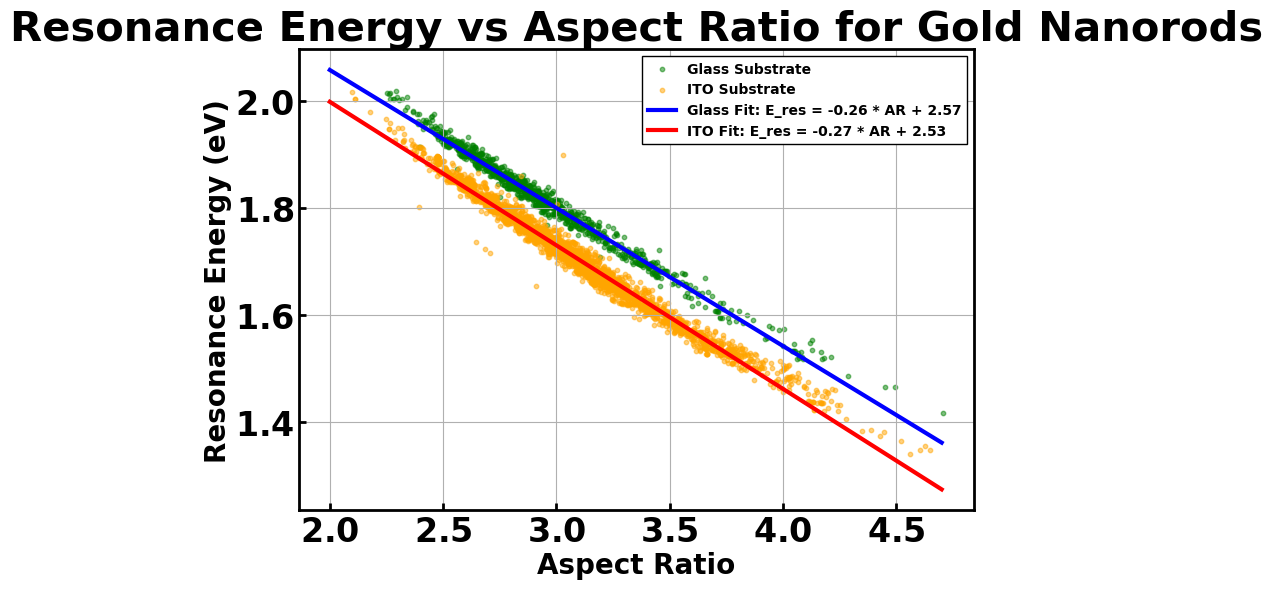

(1.799, 1.729, -0.070)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data for glass substrate
aspect_ratio_glass = glass_data['ratio']
Eres_glass = glass_data['eres']

# Data for ITO substrate
aspect_ratio_ito = ito_data['ratio']
Eres_ito = ito_data['eres']

# Define linear function
def linear_func(x, a, b):
    return a * x + b

# Fit linear function to glass data
params_glass, _ = curve_fit(linear_func, aspect_ratio_glass, Eres_glass)
a_glass, b_glass = params_glass

# Fit linear function to ITO data
params_ito, _ = curve_fit(linear_func, aspect_ratio_ito, Eres_ito)
a_ito, b_ito = params_ito

# Plot the data and the fitted lines
plt.figure(figsize=(8, 6))
plt.scatter(aspect_ratio_glass, Eres_glass, color='green', s=10, alpha=0.5, label='Glass Substrate')
plt.scatter(aspect_ratio_ito, Eres_ito, color='orange', s=10, alpha=0.5, label='ITO Substrate')

# Plot fitted lines
x_fit = np.linspace(2.0, 4.7, 100)
# x_fit = np.linspace(2.5, 4.0, 100)
plt.plot(x_fit, linear_func(x_fit, a_glass, b_glass), 'b-', label=f'Glass Fit: E_res = {a_glass:.2f} * AR + {b_glass:.2f}')
plt.plot(x_fit, linear_func(x_fit, a_ito, b_ito), 'r-', label=f'ITO Fit: E_res = {a_ito:.2f} * AR + {b_ito:.2f}')

# Add labels and legend
plt.xlabel('Aspect Ratio')
plt.ylabel('Resonance Energy (eV)')
plt.legend()
plt.title('Resonance Energy vs Aspect Ratio for Gold Nanorods')
plt.grid(True)
plt.show()

# Calculate the resonance energy shift at a specific aspect ratio
aspect_ratio_X = 3.0
E_res_glass_X = linear_func(aspect_ratio_X, a_glass, b_glass)
E_res_ito_X = linear_func(aspect_ratio_X, a_ito, b_ito)
resonance_energy_shift = E_res_ito_X - E_res_glass_X
E_res_glass_X, E_res_ito_X, resonance_energy_shift


In [19]:
import numpy as np

# Constants
omega_p = 9  # plasma frequency in eV
epsilon_inf = 9.84  # high-frequency dielectric constant
n_glass = 1.52  # effective refractive index for glass substrate
aspect_ratio = 3.0  # given aspect ratio
n_X = 1.975  # refractive index for unknown substrate

# n_eff_glass = (n_glass + 1) / 2
# n_eff_X = (n_X + 1) / 2

alpha = 0.8
n_med = 1.0
n_eff_glass = alpha*n_med + n_glass*(1-alpha)
n_eff_X = alpha*n_med + n_X*(1-alpha)

# Depolarization factor L for the given aspect ratio
L = (1 + aspect_ratio)**-1.6

# Resonance energy for glass substrate
E_res_glass = omega_p / np.sqrt(n_eff_glass**2 / L + epsilon_inf - n_eff_glass**2)

# Resonance energy for unknown substrate
E_res_X = omega_p / np.sqrt(n_eff_X**2 / L + epsilon_inf - n_eff_X**2)

# Calculate the factor F
F = E_res_X / E_res_glass

E_res_glass, E_res_X, F

(2.021, 1.939, 0.959)

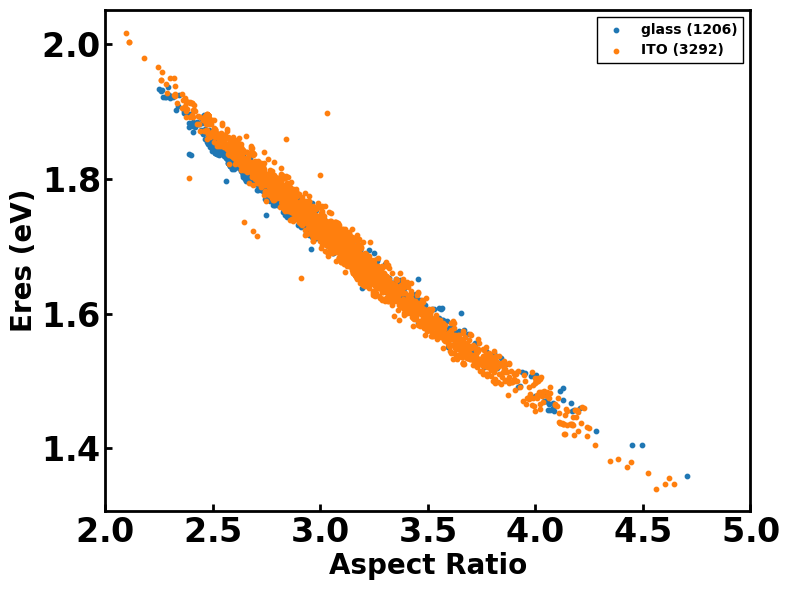

In [20]:
# Eres vs AR ITO and glass
plt.scatter(glass_data['ratio'], glass_data['eres']*F, s=10, label=f'glass ({glass_data.shape[0]})')
plt.scatter(ito_data['ratio'], ito_data['eres'], s=10, label=f'ITO ({ito_data.shape[0]})')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xlim(2, 5)
plt.legend()

In [40]:
# Randomly sample 1000 rows from each dataframe
glass_sample = glass_data.sample(n=1000, random_state=1)
ito_sample = ito_data.sample(n=1000, random_state=1)

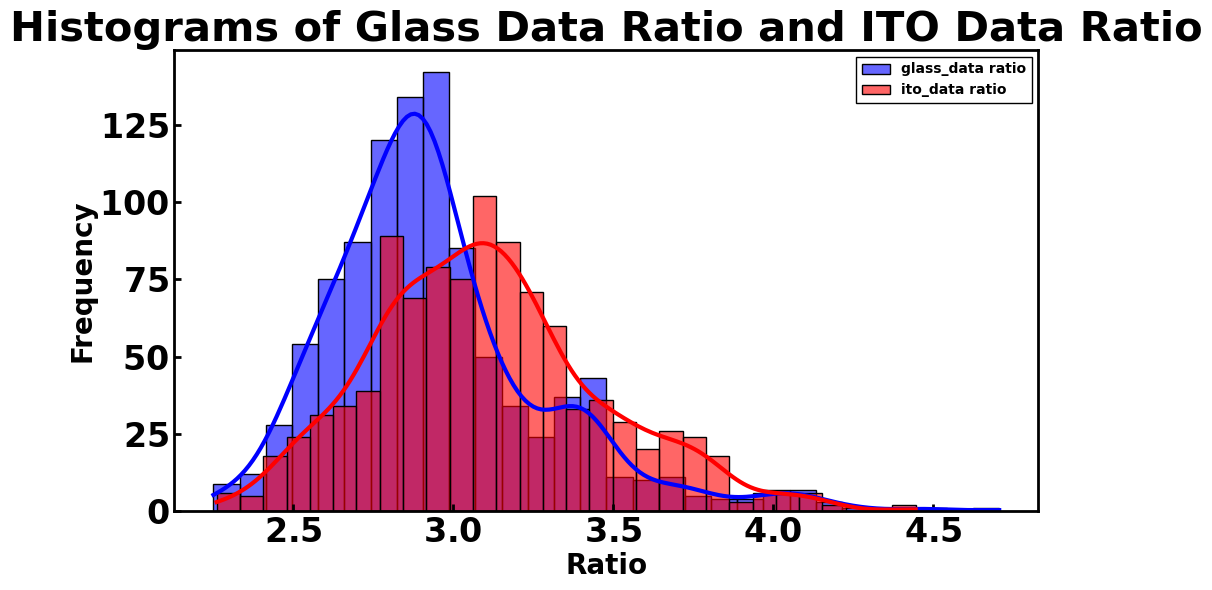

In [42]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['ratio'],
    'x2': ito_sample['ratio']
})

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the histogram for x1
sns.histplot(data['x1'], color='blue', kde=True, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the histogram for x2
sns.histplot(data['x2'], color='red', kde=True, label='ito_data ratio', bins=30, alpha=0.6)

# Add titles and labels
plt.title('Histograms of Glass Data Ratio and ITO Data Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.legend()

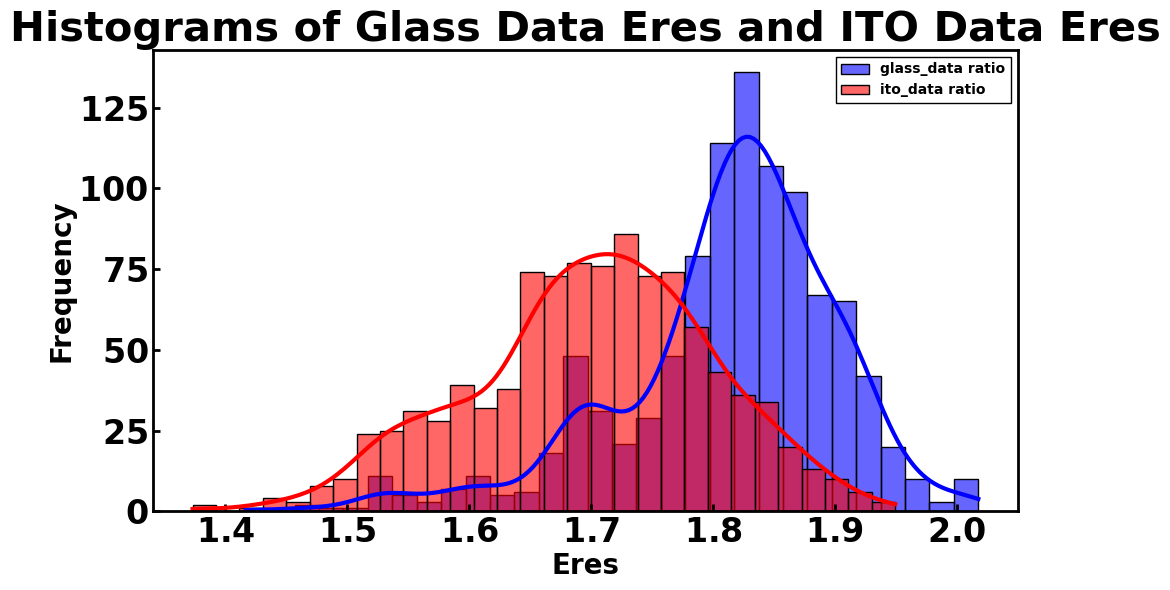

In [43]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['eres'],
    'x2': ito_sample['eres']
})

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the histogram for x1
sns.histplot(data['x1'], color='blue', kde=True, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the histogram for x2
sns.histplot(data['x2'], color='red', kde=True, label='ito_data ratio', bins=30, alpha=0.6)

# Add titles and labels
plt.title('Histograms of Glass Data Eres and ITO Data Eres')
plt.xlabel('Eres')
plt.ylabel('Frequency')
plt.legend()

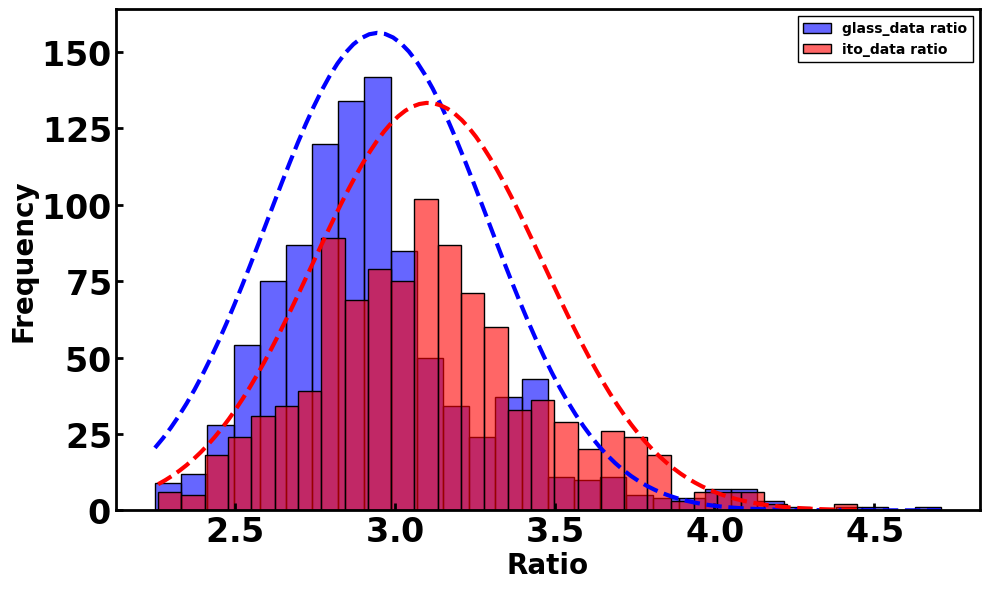

In [45]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['ratio'],
    'x2': ito_sample['ratio']
})

# Calculate the mean and standard deviation for x1 and x2
mean_x1, std_x1 = data['x1'].mean(), data['x1'].std()
mean_x2, std_x2 = data['x2'].mean(), data['x2'].std()

# Create an array of values for plotting the normal distribution
x1_values = np.linspace(data['x1'].min(), data['x1'].max(), 100)
x2_values = np.linspace(data['x2'].min(), data['x2'].max(), 100)

# Calculate the normal distribution values
x1_normal = norm.pdf(x1_values, mean_x1, std_x1)
x2_normal = norm.pdf(x2_values, mean_x2, std_x2)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the histogram for x1
sns.histplot(data['x1'], color='blue', kde=False, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x1
plt.plot(x1_values, x1_normal * len(data['x1']) * (data['x1'].max() - data['x1'].min()) / 30, color='blue', linestyle='dashed')

# Plot the histogram for x2
sns.histplot(data['x2'], color='red', kde=False, label='ito_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x2
plt.plot(x2_values, x2_normal * len(data['x2']) * (data['x2'].max() - data['x2'].min()) / 30, color='red', linestyle='dashed')

# Add titles and labels
# plt.title('Histograms and Normal Distribution Fits of Glass Data Ratio and ITO Data Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.legend()

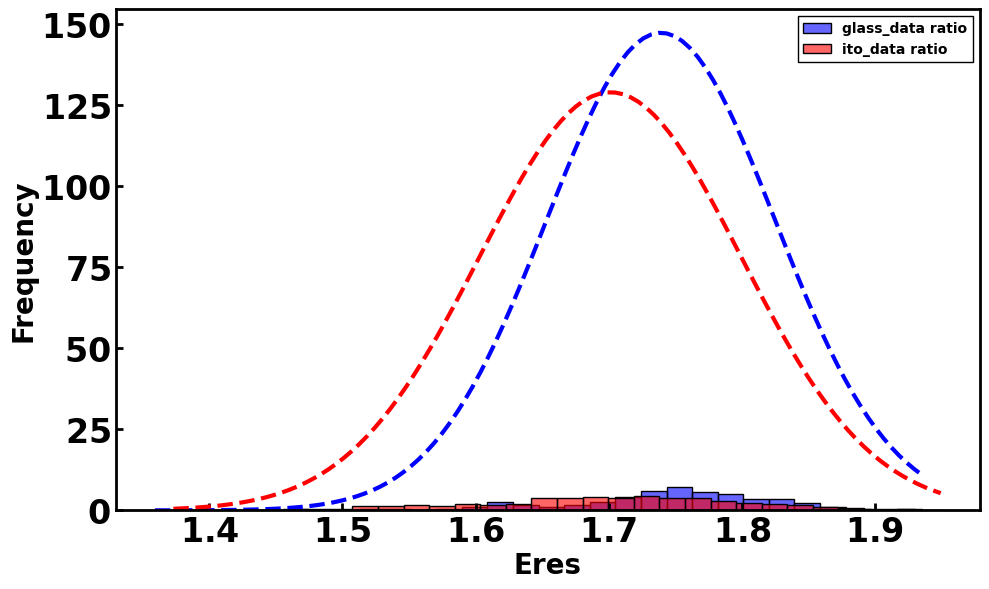

In [50]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['eres']*F,
    'x2': ito_sample['eres']
})

# Calculate the mean and standard deviation for x1 and x2
mean_x1, std_x1 = data['x1'].mean(), data['x1'].std()
mean_x2, std_x2 = data['x2'].mean(), data['x2'].std()

# Create an array of values for plotting the normal distribution
x1_values = np.linspace(data['x1'].min(), data['x1'].max(), 100)
x2_values = np.linspace(data['x2'].min(), data['x2'].max(), 100)

# Calculate the normal distribution values
x1_normal = norm.pdf(x1_values, mean_x1, std_x1)
x2_normal = norm.pdf(x2_values, mean_x2, std_x2)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the histogram for x1
sns.histplot(data['x1'], color='blue', kde=False, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x1
plt.plot(x1_values, x1_normal * len(data['x1']) * (data['x1'].max() - data['x1'].min()) / 30, color='blue', linestyle='dashed')

# Plot the histogram for x2
sns.histplot(data['x2'], color='red', kde=False, label='ito_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x2
plt.plot(x2_values, x2_normal * len(data['x2']) * (data['x2'].max() - data['x2'].min()) / 30, color='red', linestyle='dashed')

# Add titles and labels
# plt.title('Histograms and Normal Distribution Fits of Glass Data Ratio and ITO Data Ratio')
plt.xlabel('Eres')
plt.ylabel('Frequency')
plt.legend()

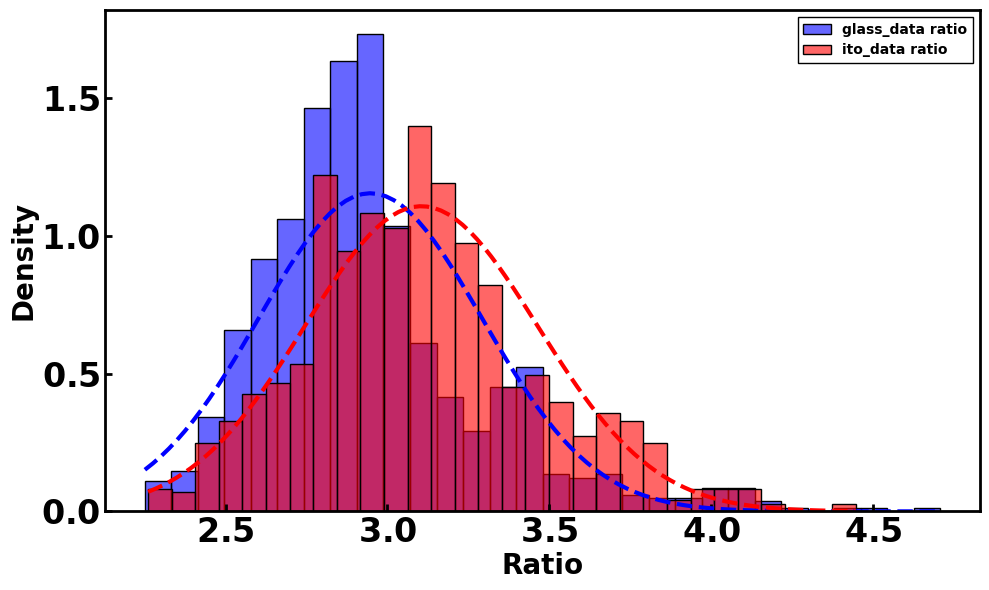

In [53]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['ratio'],
    'x2': ito_sample['ratio']
})

# Calculate the mean and standard deviation for x1 and x2
mean_x1, std_x1 = data['x1'].mean(), data['x1'].std()
mean_x2, std_x2 = data['x2'].mean(), data['x2'].std()

# Create an array of values for plotting the normal distribution
x1_values = np.linspace(data['x1'].min(), data['x1'].max(), 100)
x2_values = np.linspace(data['x2'].min(), data['x2'].max(), 100)

# Calculate the normal distribution values
x1_normal = norm.pdf(x1_values, mean_x1, std_x1)
x2_normal = norm.pdf(x2_values, mean_x2, std_x2)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the normalized histogram for x1
sns.histplot(data['x1'], color='blue', stat='density', kde=False, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x1
plt.plot(x1_values, x1_normal, color='blue', linestyle='dashed')

# Plot the normalized histogram for x2
sns.histplot(data['x2'], color='red', stat='density', kde=False, label='ito_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x2
plt.plot(x2_values, x2_normal, color='red', linestyle='dashed')

# Add titles and labels
# plt.title('Normalized Histograms and Normal Distribution Fits of Glass Data Ratio and ITO Data Ratio')
plt.xlabel('Ratio')
plt.ylabel('Density')
plt.legend()

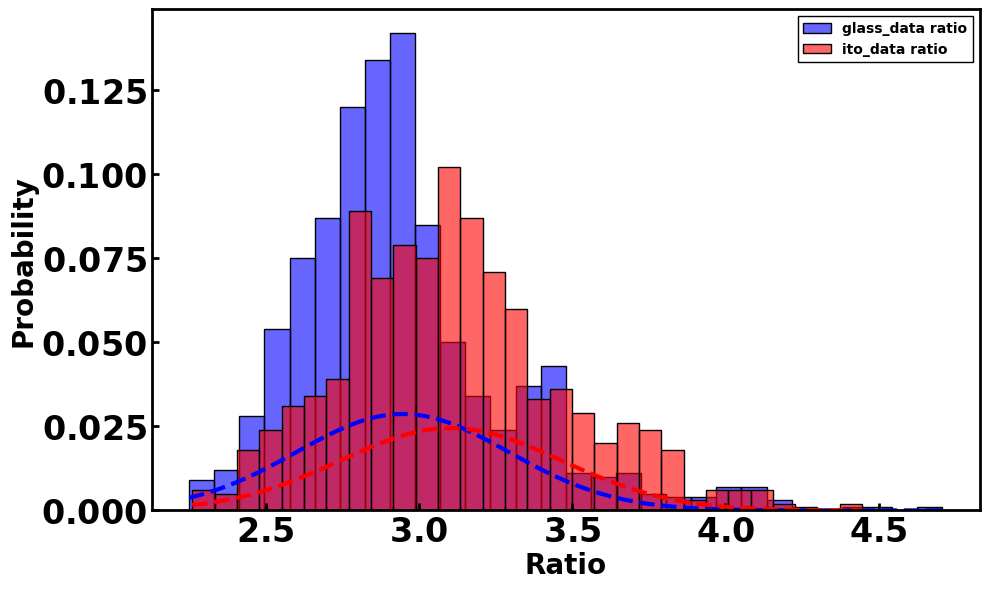

In [55]:
# Create a new dataframe with x1 and x2 from the 'ratio' columns
data = pd.DataFrame({
    'x1': glass_sample['ratio'],
    'x2': ito_sample['ratio']
})

# Calculate the mean and standard deviation for x1 and x2
mean_x1, std_x1 = data['x1'].mean(), data['x1'].std()
mean_x2, std_x2 = data['x2'].mean(), data['x2'].std()

# Create an array of values for plotting the normal distribution
x1_values = np.linspace(data['x1'].min(), data['x1'].max(), 100)
x2_values = np.linspace(data['x2'].min(), data['x2'].max(), 100)

# Calculate the normal distribution values
x1_normal = norm.pdf(x1_values, mean_x1, std_x1)
x2_normal = norm.pdf(x2_values, mean_x2, std_x2)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot the histogram for x1 with probability normalization
sns.histplot(data['x1'], color='blue', stat='probability', kde=False, label='glass_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x1
plt.plot(x1_values, x1_normal * (x1_values[1] - x1_values[0]), color='blue', linestyle='dashed')

# Plot the histogram for x2 with probability normalization
sns.histplot(data['x2'], color='red', stat='probability', kde=False, label='ito_data ratio', bins=30, alpha=0.6)

# Plot the normal distribution for x2
plt.plot(x2_values, x2_normal * (x2_values[1] - x2_values[0]), color='red', linestyle='dashed')

# Add titles and labels
# plt.title('Probability Histograms and Normal Distribution Fits of Glass Data Ratio and ITO Data Ratio')
plt.xlabel('Ratio')
plt.ylabel('Probability')
plt.legend()